# packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
import array
import xarray as xr
import cmocean.cm as cmocean
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
import pathlib
from pathlib import Path
import os
import netCDF4
from netCDF4 import Dataset as nc
import glidertools as gt
import gsw
import cmocean
import cmocean.cm as cmo
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

In [2]:
ds_glider = xr.open_dataset('ds_distance.nc')

# mixed layer

In [3]:
mixed_layer_densities = []

for i in range(len(ds_glider.distance)):
    # Calculate density for the current ATD point
    density = gsw.sigma0(ds_glider.salinity.isel(distance=i), ds_glider.temp.isel(distance=i)).expand_dims(distance=ds_glider.distance)
    
    # Select reference depth based on the value of ATD
    if ds_glider.distance.isel(distance=i).item() == 0:
        reference_depth = 13
    else:
        reference_depth = 10
    
    # Calculate the reference density at the chosen reference depth
    reference_density = density.sel(ctd_depth=reference_depth)
    density_difference = density - reference_density
    
    # Find the index where the difference is greater than the threshold for the first time
    mixed_layer_index_flat = np.argmax((density_difference > 0.03).values)
    
    # Get the depth index where the difference is greater than the threshold for the first time
    mixed_layer_index = mixed_layer_index_flat.item()
    
    # Get the density value at that depth for the current ATD point
    mixed_layer_density = density.isel(ctd_depth=mixed_layer_index, distance=i)
    
    # Append the mixed layer density directly to the list
    mixed_layer_densities.append(mixed_layer_density)

# Concatenate the list of mixed layer densities along the ATD dimension
mixed_layer_densities = xr.concat(mixed_layer_densities, dim=ds_glider.distance)


In [4]:
# NaN zero values
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0.0, np.nan)
mixed_layer_densities['ctd_depth'] = mixed_layer_densities['ctd_depth'].where(mixed_layer_densities['ctd_depth'] != 0., np.nan)
MLD = mixed_layer_densities.ctd_depth

In [5]:
np.mean(MLD)

<xarray.DataArray 'ctd_depth' ()>
array(34.41574074)

# calculation of horizontal and vertical buoyancy gradients

In [6]:
rho_sorted = np.empty((len(ds_glider.ctd_depth.data),len(ds_glider.distance.data)))

rho = gsw.density.rho(ds_glider.salinity, ds_glider.temp, ds_glider.p)

# Sort density while keeping NaNs in their original positions
for i in range(len(ds_glider.distance.data)):
    arr = rho.data[:, i]
    nan_mask = np.isnan(arr)
    non_nan_values = arr[~nan_mask]
    
    # Sort non-NaN values
    sorted_non_nan_values = np.sort(non_nan_values)
    
    # Create a copy of the original array to preserve NaN positions
    sorted_arr = np.copy(arr)
    
    # Replace non-NaN values in the sorted array
    sorted_arr[~nan_mask] = sorted_non_nan_values
    
    # Store in rho_sorted
    rho_sorted[:, i] = sorted_arr
    

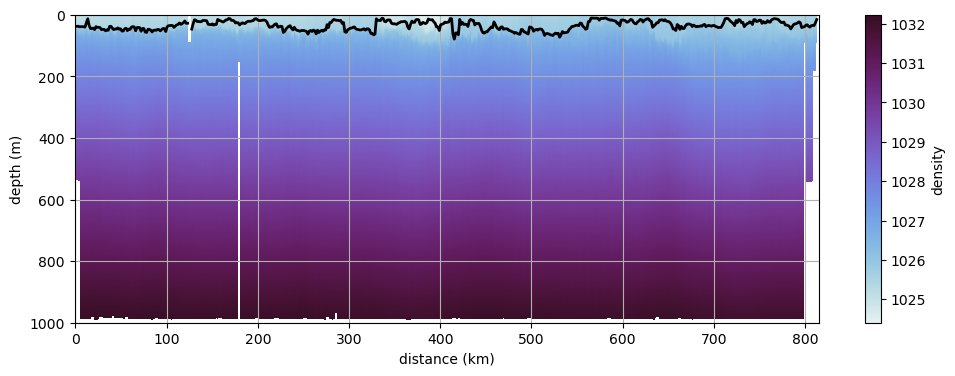

In [7]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,rho_sorted,cmap=cmo.dense)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('density')

#plt.plot(ds.distance,)

In [8]:
g = 9.81
ref_rho = 1025

b = g*(ref_rho - rho_sorted)/ref_rho

b

array([[        nan,         nan,         nan, ..., -0.00489036,
                nan,         nan],
       [        nan,         nan, -0.00093542, ..., -0.00490742,
                nan,         nan],
       [        nan, -0.00063719, -0.00095164, ..., -0.00492679,
        -0.00509402,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

# horizontal buoyancy gradient

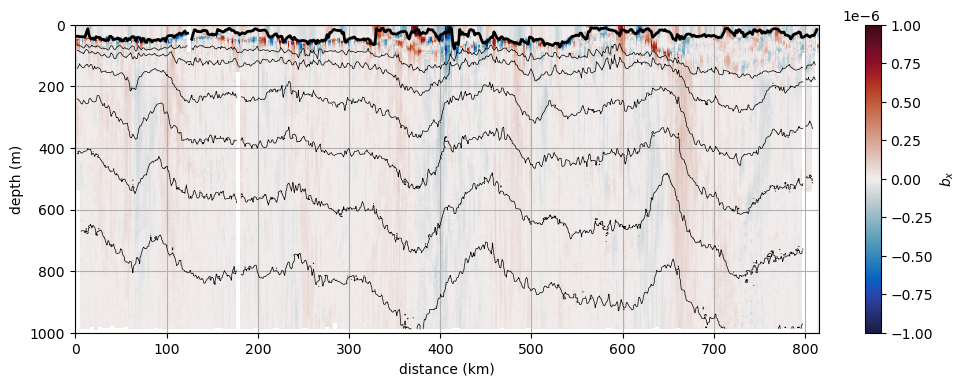

In [9]:
density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26.4  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

by = (np.diff(b, axis=1)/1500)

zero_column = np.zeros((by.shape[0], 1))

by = np.hstack([by,zero_column])

# Custom moving average function that excludes NaN values
def moving_average_with_nan(x, window_size):
    y = np.copy(x)  # Copy of the original array to avoid modifying it directly
    for i in range(len(x)):
        # Define the window range around the current index
        window_start = max(0, i - window_size // 2)
        window_end = min(len(x), i + window_size // 2 + 1)
        window = x[window_start:window_end]
        
        # Exclude NaN values from the window
        valid_window = window[~np.isnan(window)]
        
        # Calculate mean only if there are valid (non-NaN) values
        y[i] = np.mean(valid_window) if len(valid_window) > 0 else np.nan
    return y

# Track NaN positions in rho_sorted
nan_mask_b = np.isnan(by)

# First, smooth along the depth axis (axis=0)
#rho_smoothed_depth = np.apply_along_axis(moving_average_with_nan, 0, rho_sorted, window_size=10)

# Next, smooth along the distance axis (axis=1)
by_smoothed = np.apply_along_axis(moving_average_with_nan, 1, by, window_size=5)

# Restore NaN values to their original positions
by_smoothed[nan_mask_b] = np.nan



plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,by_smoothed,cmap=cmo.balance, vmin= -1e-6, vmax=1e-6)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('$b_x$')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

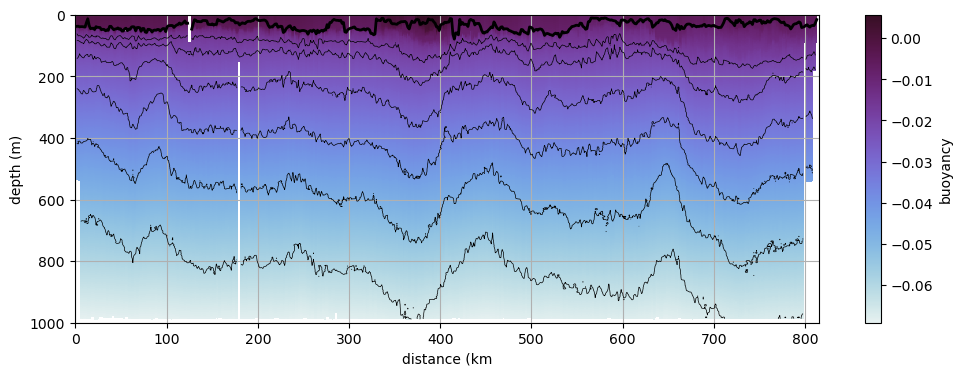

In [10]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,b,cmap=cmo.dense)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)

plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('buoyancy')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

In [11]:
M4 = (by_smoothed)**2


M4

array([[           nan,            nan,            nan, ...,
                   nan,            nan, 0.00000000e+00],
       [           nan,            nan, 2.04061239e-17, ...,
                   nan,            nan, 0.00000000e+00],
       [           nan, 8.50916652e-18, 2.40630719e-15, ...,
        1.69704446e-16,            nan, 3.10720816e-15],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan, 0.00000000e+00],
       [           nan,            nan,            nan, ...,
                   nan,            nan, 0.00000000e+00],
       [           nan,            nan,            nan, ...,
                   nan,            nan, 0.00000000e+00]])

# shear


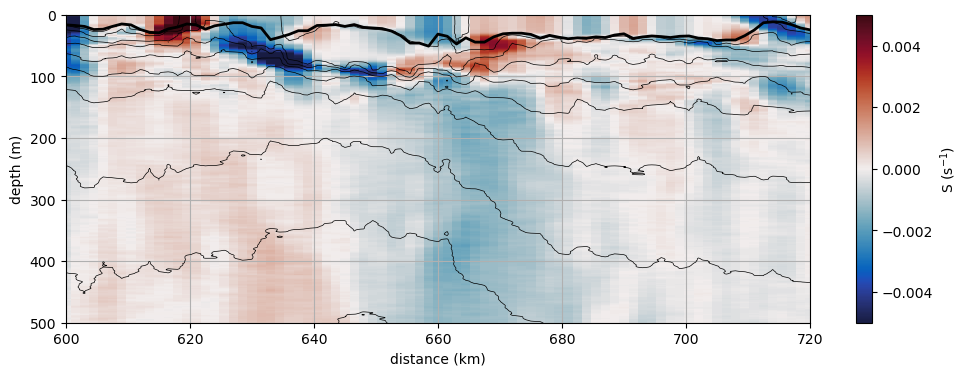

In [12]:
omega = 7.2921e-5

f = 2*omega*np.sin(np.deg2rad(ds_glider.lat)).values

S = by_smoothed/f

# Convert the 2D array `gv_ref_bottom` to a DataFrame
df = pd.DataFrame(S)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply Gaussian filter
sigma = 1  # Adjust this parameter for more or less smoothing
S_smoothed_gaussian = gaussian_filter(df.fillna(0), sigma=sigma)

# Restore NaN values
shear = np.where(nan_mask, np.nan,S_smoothed_gaussian)

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 25  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,shear,cmap=cmo.balance, vmin=-0.005, vmax=0.005)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.xlim(600,720)
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('S (s$^{-1}$)')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Stratification

(600.0, 720.0)

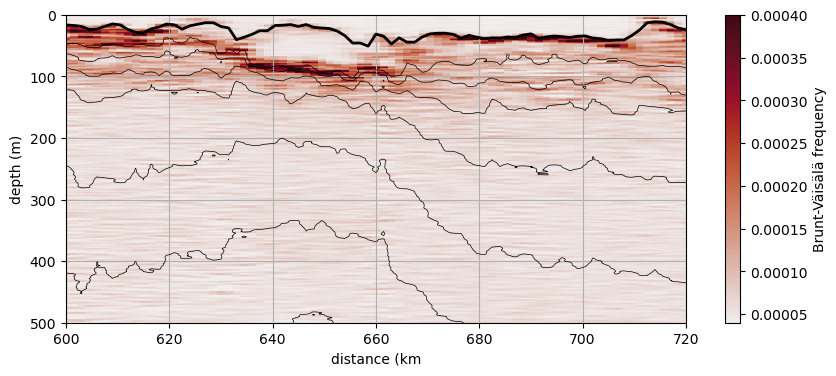

In [13]:
# Assuming uniform depth spacing, calculate delta z
import matplotlib.colors as mcolors

density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)

# Generate levels for the contour lines
# Specify the beginning, ending, and spacing
beginning = 26  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)

N2 = (np.diff(b, axis=0)/-0.5)

zero_row = np.zeros((1, N2.shape[1]))  # Create a row of zeros with shape (1, 610)

# Concatenate the zero row to the top of N2
N2 = np.vstack([zero_row, N2])



# Custom moving average function that excludes NaN values
def moving_average_with_nan(x, window_size):
    """
    Smooth data using a moving average, ignoring NaN values.

    Parameters:
    x (np.ndarray): 1D array to be smoothed.
    window_size (int): Size of the moving window.

    Returns:
    np.ndarray: Smoothed 1D array.
    """
    y = np.copy(x)  # Copy to avoid modifying the original array
    for i in range(len(x)):
        # Define the window range
        window_start = max(0, i - window_size // 2)
        window_end = min(len(x), i + window_size // 2 + 1)
        window = x[window_start:window_end]
        
        # Exclude NaN values
        valid_window = window[~np.isnan(window)]
        
        # Compute mean if valid values exist
        y[i] = np.mean(valid_window) if len(valid_window) > 0 else np.nan
    return y

# Assuming 'by' is your 2D array with depth as axis=0
nan_mask_N2 = np.isnan(N2)  # Track NaN positions

# Apply vertical smoothing along the depth axis (axis=0)
N2 = np.apply_along_axis(moving_average_with_nan, 0, N2, window_size=3)

# Restore NaN values to their original positions
N2[nan_mask_N2] = np.nan

# Convert the 2D array `gv_ref_bottom` to a DataFrame
df = pd.DataFrame(N2)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply Gaussian filter
sigma = 1  # Adjust this parameter for more or less smoothing
N2_smoothed_gaussian = gaussian_filter(df.fillna(0), sigma=sigma)

# Restore NaN values
N2 = np.where(nan_mask, np.nan,N2_smoothed_gaussian)



plt.figure(figsize=(10,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,N2,cmap=cmo.amp,vmin=0.4e-4, vmax= 4e-4)





plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('Brunt-Väisälä frequency')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
plt.contour(ds_glider.distance,ds_glider.ctd_depth,N2,levels=[0], colors='blue', linewidths=1)

plt.xlim(600,720)


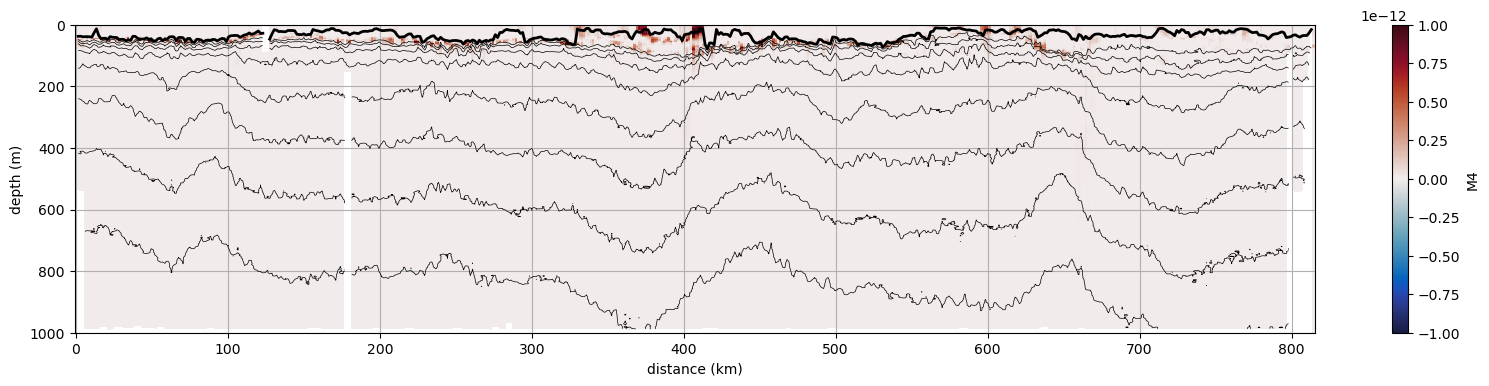

In [14]:
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,M4,cmap=cmo.balance, vmin= -1e-12, vmax = 1e-12)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('M4')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#plt.contour(ds_glider.distance,ds_glider.ctd_depth,np.sqrt(M4),levels=[-0.000001], colors='darkblue', linewidths=0.5)

# EPV calculation

In [15]:
omega = 7.2921e-5

f = 2*omega*np.sin(np.deg2rad(ds_glider.lat)).values

PV = f*N2 - M4/f
np.shape(PV)

(2001, 544)

# EPV plot

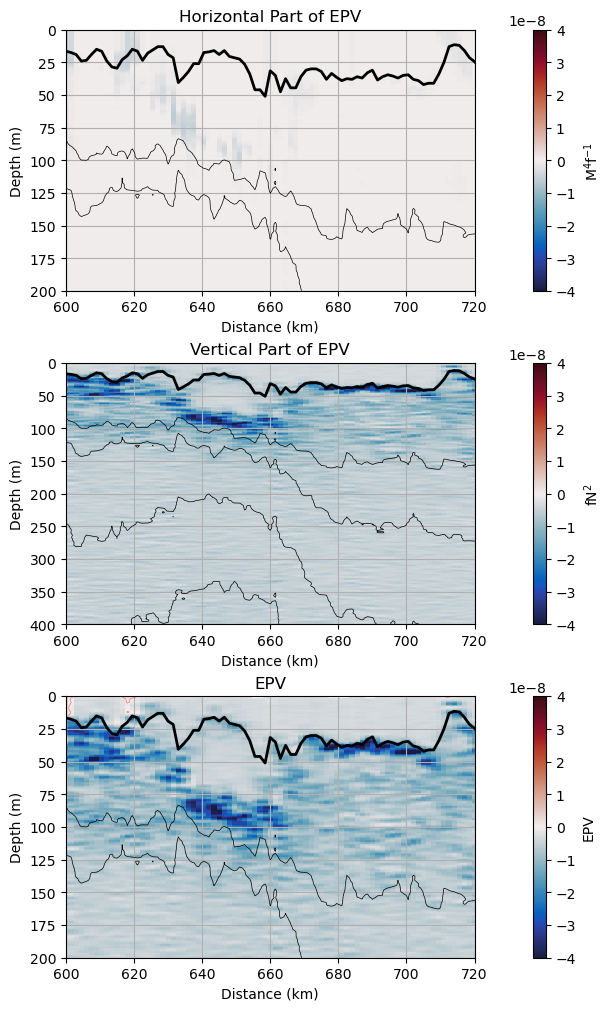

In [20]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo

fig, axs = plt.subplots(3, 1, figsize=(6, 10), constrained_layout=True)

# Plot 1: Horizontal Part of PV
pc1 = axs[0].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, M4/f, cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
axs[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[0].set_xlim(600, 720)
axs[0].set_ylim(0, 200)
axs[0].invert_yaxis()
axs[0].set_xlabel('Distance (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].grid()
axs[0].set_title('Horizontal Part of EPV')
fig.colorbar(pc1, ax=axs[0], label='M$^4$f$^{-1}$')
axs[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Plot 2: Vertical Part of PV
pc2 = axs[1].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, f*N2, cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
axs[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[1].set_xlim(600, 720)
axs[1].set_ylim(0, 400)
axs[1].invert_yaxis()
axs[1].set_xlabel('Distance (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].grid()
axs[1].set_title('Vertical Part of EPV')
fig.colorbar(pc2, ax=axs[1], label='fN$^2$')
axs[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Plot 3: EPV
pc3 = axs[2].pcolormesh(ds_glider.distance, ds_glider.ctd_depth, PV, cmap=cmo.balance, vmin=-4e-8, vmax=4e-8)
axs[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[2].set_xlim(600, 720)
axs[2].set_ylim(0, 200)
axs[2].invert_yaxis()
axs[2].set_xlabel('Distance (km)')
axs[2].set_ylabel('Depth (m)')
axs[2].grid()
axs[2].set_title('EPV')
fig.colorbar(pc3, ax=axs[2], label='EPV')
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, PV, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

plt.show()


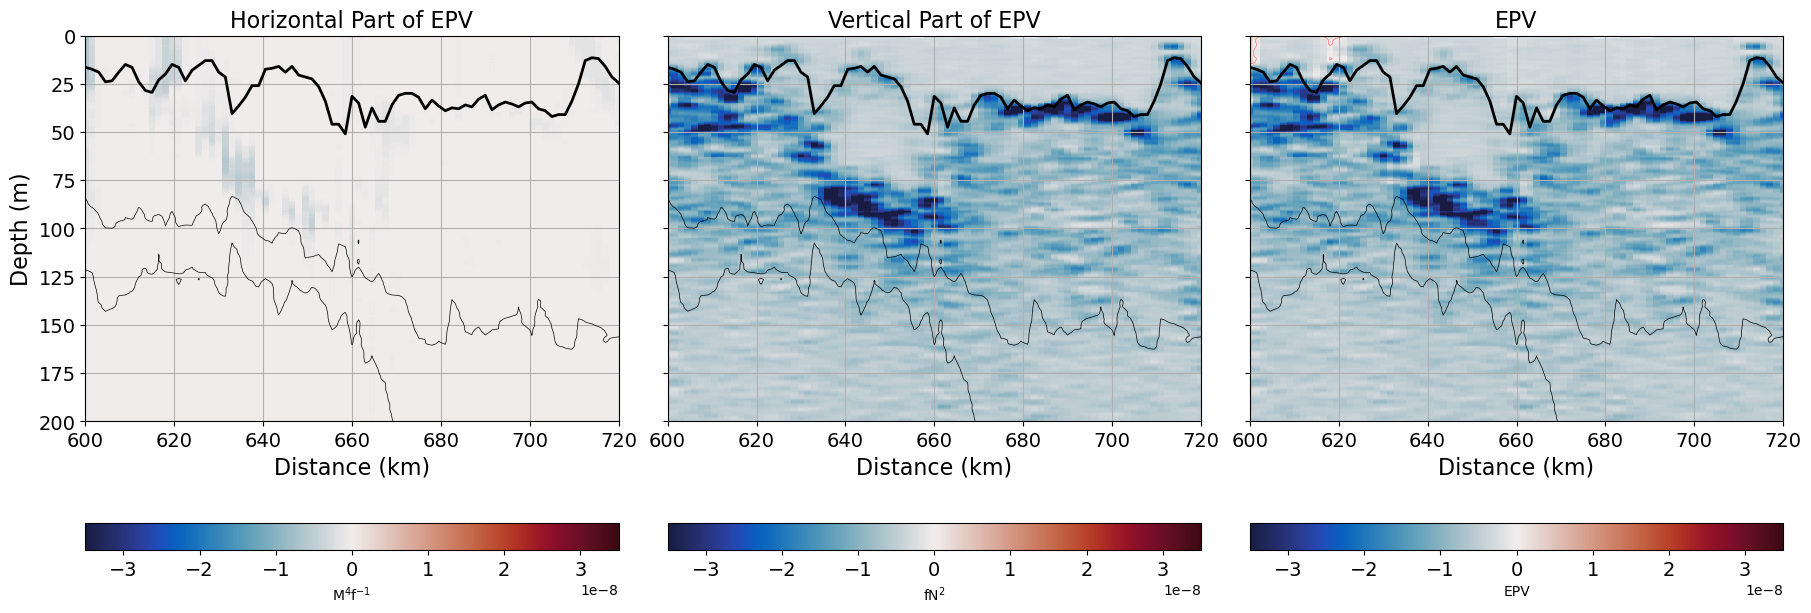

In [23]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Plot 1: Horizontal Part of PV
pc1 = axs[0].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, M4/f,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[0].set_xlim(600, 720)
axs[0].set_ylim(0, 200)
axs[0].invert_yaxis()
axs[0].set_xlabel('Distance (km)', fontsize=16)
axs[0].set_ylabel('Depth (m)', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].grid()
axs[0].set_title('Horizontal Part of EPV', fontsize=16)
fig.colorbar(pc1, ax=axs[0], label='M$^4$f$^{-1}$', orientation='horizontal', pad=0.1).ax.tick_params(labelsize=14)
cs0 = axs[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
axs[0].clabel(cs0, inline=True, fontsize=12, fmt="%.1f")  # Add labels to contours in ax[0]

# Plot 2: Vertical Part of PV
pc2 = axs[1].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, f*N2,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[1].set_xlim(600, 720)
axs[1].set_ylim(0, 200)
axs[1].invert_yaxis()
axs[1].set_xlabel('Distance (km)', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].grid()
axs[1].set_title('Vertical Part of EPV', fontsize=16)
fig.colorbar(pc2, ax=axs[1], label='fN$^2$', orientation='horizontal', pad=0.1).ax.tick_params(labelsize=14)
axs[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Remove y-axis labels and ticks for the second plot
axs[1].set_yticklabels([])
axs[1].set_ylabel('')

# Plot 3: EPV
pc3 = axs[2].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, PV,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[2].set_xlim(600, 720)
axs[2].set_ylim(0, 200)
axs[2].invert_yaxis()
axs[2].set_xlabel('Distance (km)', fontsize=16)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].grid()
axs[2].set_title('EPV', fontsize=16)
fig.colorbar(pc3, ax=axs[2], label='EPV', orientation='horizontal', pad=0.1).ax.tick_params(labelsize=14)
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, PV, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

# Remove y-axis labels and ticks for the third plot
axs[2].set_yticklabels([])
axs[2].set_ylabel('')

# Save the figure
plt.savefig('EPV_zoomed', bbox_inches='tight', dpi=100)
# Show the figure
plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_16964\1510277773.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


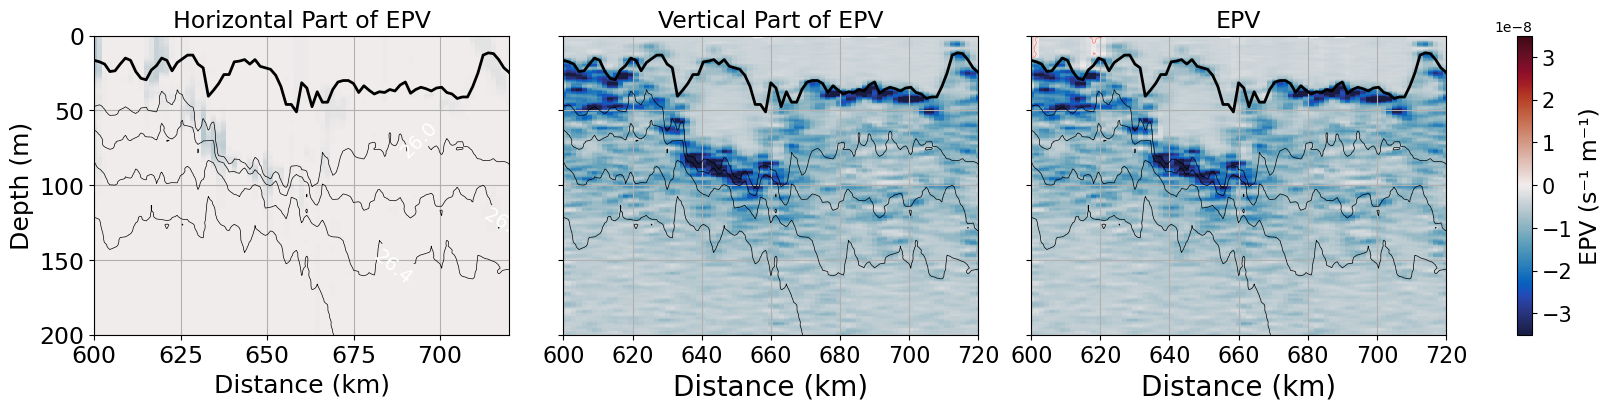

In [28]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

# Plot 1: Horizontal Part of PV
pc1 = axs[0].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, M4/f,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[0].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[0].set_xlim(600, 720)
axs[0].set_ylim(0, 200)
axs[0].invert_yaxis()
axs[0].set_xlabel('Distance (km)', fontsize=18
                 )
axs[0].set_ylabel('Depth (m)', fontsize=18)
axs[0].tick_params(axis='both', labelsize=17)
axs[0].grid()
axs[0].set_title('Horizontal Part of EPV', fontsize=17)
cs0 = axs[0].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
axs[0].clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='white', manual=label_positions)

# Plot 2: Vertical Part of PV
pc2 = axs[1].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, f*N2,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[1].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[1].set_xlim(600, 720)
axs[1].set_ylim(0, 200)
axs[1].invert_yaxis()
axs[1].set_xlabel('Distance (km)', fontsize=20)
axs[1].tick_params(axis='both', labelsize=16)
axs[1].grid()
axs[1].set_title('Vertical Part of EPV', fontsize=17)
axs[1].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Remove y-axis labels and ticks for the second plot
axs[1].set_yticklabels([])
axs[1].set_ylabel('')

# Plot 3: EPV
pc3 = axs[2].pcolormesh(
    ds_glider.distance, ds_glider.ctd_depth, PV,
    cmap=cmo.balance, vmin=-3.5e-8, vmax=3.5e-8
)
axs[2].plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
axs[2].set_xlim(600, 720)
axs[2].set_ylim(0, 200)
axs[2].invert_yaxis()
axs[2].set_xlabel('Distance (km)', fontsize=20)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].grid()
axs[2].set_title('EPV', fontsize=17)
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
axs[2].contour(ds_glider.distance, ds_glider.ctd_depth, PV, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

# Remove y-axis labels and ticks for the third plot
axs[2].set_yticklabels([])
axs[2].set_ylabel('')

# Add a single colorbar to the right of all plots with units
cbar = fig.colorbar(pc3, ax=axs, location='right', pad=0.02)
cbar.set_label('EPV (s⁻¹ m⁻¹)', fontsize=17)  # Adding the units
cbar.ax.tick_params(labelsize=15)  # Adjust tick size for the colorbar

# Save the figure
plt.savefig('EPV_zoomed', bbox_inches='tight', dpi=100)

# Show the figure
plt.show()


# Ri number

In [16]:

Ri = N2*f**2/M4

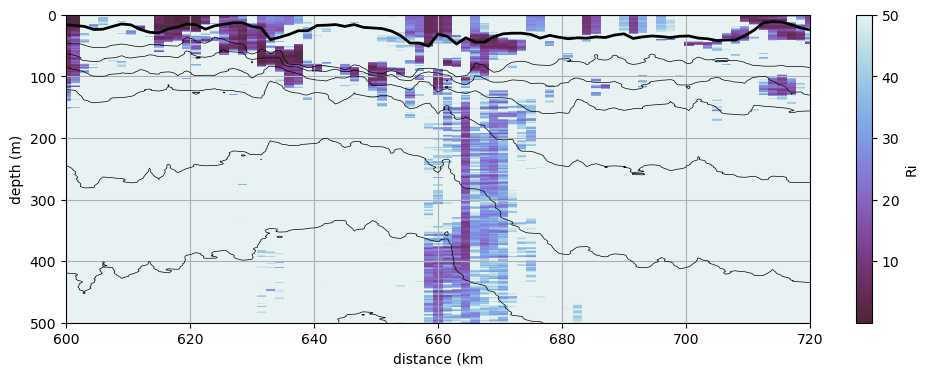

In [17]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,Ri,vmax=50, cmap=cmo.dense_r, alpha=0.9)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.xlim(600,720)
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('Ri')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

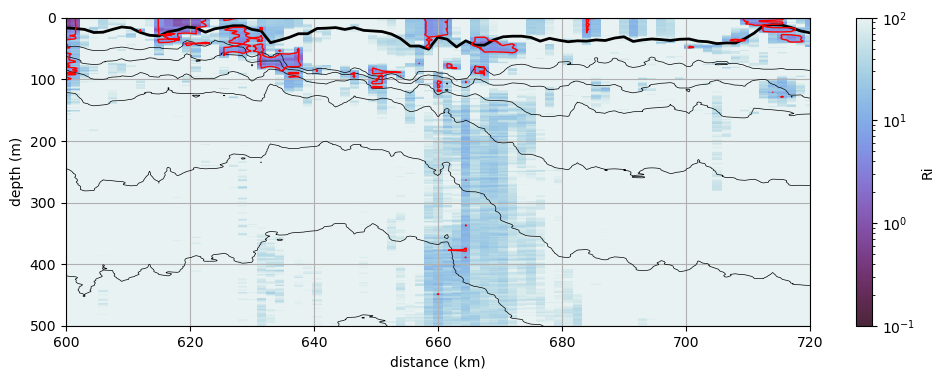

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean  # Assuming you use the `cmo` colormap from `cmocean`

# Replace zeros in Ri with a small positive value for logarithmic scaling
Ri_safe = np.where(Ri > 0, Ri, 1e-3)

plt.figure(figsize=(12, 4))
# Use LogNorm to apply a logarithmic scale to the color mapping
plt.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, Ri_safe, 
               cmap=cmo.dense_r, norm=LogNorm(vmin=1e-1, vmax=1e2), alpha=0.9)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, 
         color='k', linewidth=2)
plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.xlim(600, 720)
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')


# Add a colorbar with log scale labels
cbar = plt.colorbar()
cbar.set_label('Ri')

# Add contours
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, 
            levels=levels, colors='k', linewidths=0.5)
plt.contour(ds_glider.distance, ds_glider.ctd_depth, Ri, levels=[10], colors='red', linewidths=1)


plt.show()


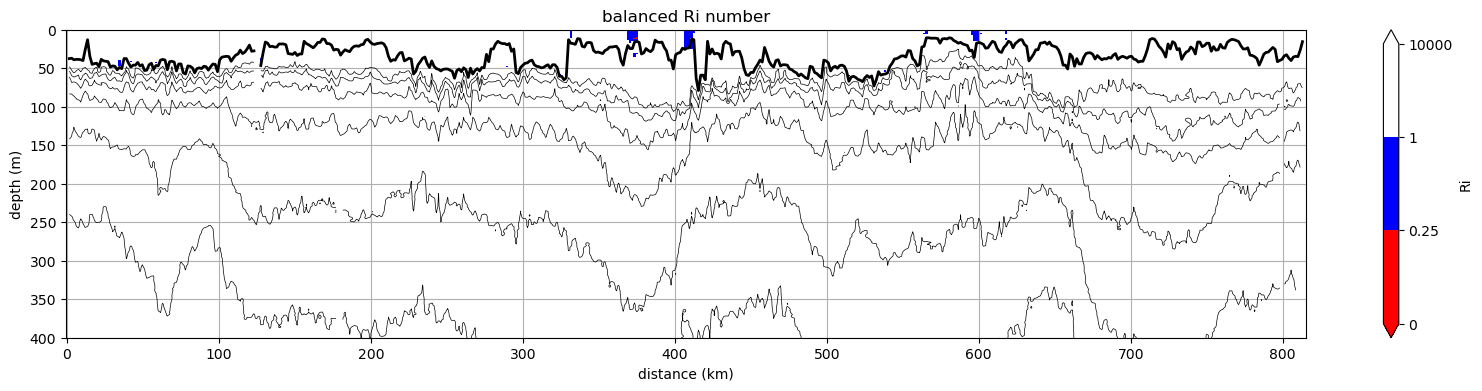

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Custom colormap for different stability regimes (red, green, white)
cmap = mcolors.ListedColormap(['red', 'blue', 'white'])

# Norm with boundaries 
norm = mcolors.BoundaryNorm([0.000001, 0.25, 1, 10000], cmap.N)

# Plot the data
plt.figure(figsize=(20, 4))
mesh = plt.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, Ri, cmap=cmap, norm=norm)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
plt.ylim(0,400)
plt.gca().invert_yaxis()
plt.grid()

# Set axis labels
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

# Customizing the colorbar
cbar = plt.colorbar(mesh, extend='both', boundaries=[0.1, 1, 10, 10000])
cbar.set_label('Ri')
cbar.set_ticks([0, 0.25, 1, 10000])
cbar.set_ticklabels(['0', '0.25', '1', '10000'])

#cbar.set_ticks([0.125, 0.75, 5000])
#cbar.set_ticklabels(['unstable', 'weekly unstable', 'stable'])

# Overlay density contours
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
plt.title('balanced Ri number') 
plt.show()



In [20]:
ds_glider['AOU'] = ds_glider.sol - ds_glider.o2

# Step 2: Calculate the mean AOU between 300m and 700m
depth_range = (ds_glider.ctd_depth >= 300) & (ds_glider.ctd_depth <= 700)
mean_AOU = ds_glider.AOU.where(depth_range, drop=True).mean(dim='ctd_depth')

# geostrophic velocity

In [21]:
Rd = np.nanmean(np.sqrt(N2))*1000/np.abs(np.nanmean(f))
Rd

89186.04006882888

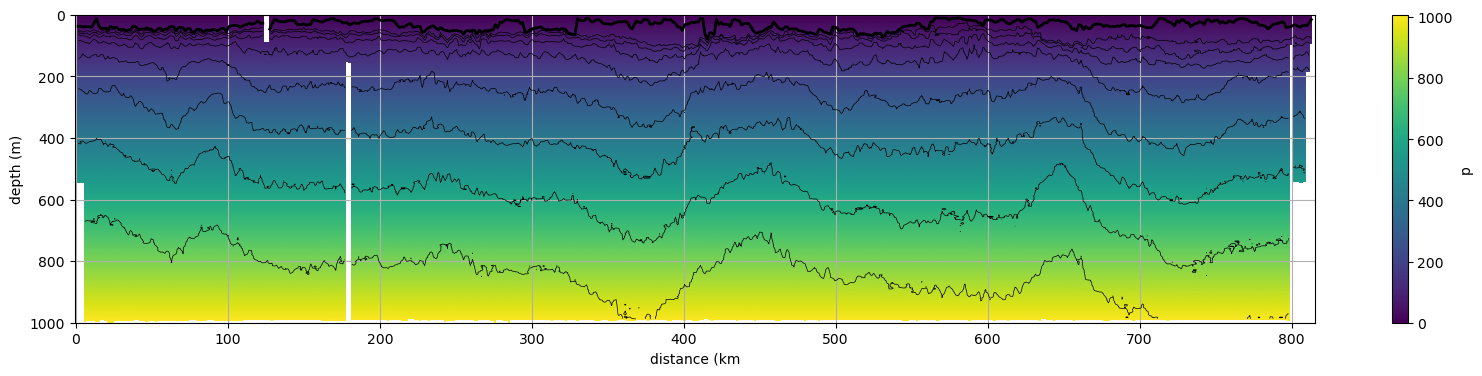

In [22]:
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,ds_glider.p)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('p')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

In [23]:
import numpy as np

# Assume ds_glider.p is your pressure DataArray
pressure_values = ds_glider.p.values  # Convert to NumPy array

# Calculate the differences along the ctd_depth dimension (assumed to be axis 0)
pressure_diff = np.diff(pressure_values, axis=0)

# Find indices where pressure is decreasing
decreasing_indices = np.where(pressure_diff <= 0)[0]  # This will give you indices of where the decrease occurs

# Print the indices where pressure is decreasing
print("Indices where pressure is decreasing:", decreasing_indices)
np.shape(decreasing_indices)

Indices where pressure is decreasing: [   0    0    0 ... 1999 1999 1999]


(2699,)

In [24]:
import numpy as np
import xarray as xr

# Get the pressure values as a NumPy array
pressure_values = ds_glider.p.values  # shape: (ctd_depth, distance)

# Calculate the pressure difference along the ctd_depth dimension
pressure_diff = np.diff(pressure_values, axis=0)

# Create a mask for decreasing pressure values
decreasing_mask = pressure_diff <= 0

# Set the corresponding values in pressure_values to NaN
# Since pressure_diff is one dimension smaller, we need to expand it to set NaN
pressure_values[1:][decreasing_mask] = np.nan  # Start from index 1 to match dimensions

# Reflect the change back to the DataArray
ds_glider['p'] = (ds_glider.p.dims, pressure_values)  # Maintain the original dimensions


In [25]:


# Call the function
dyn_height = gsw.geostrophy.geo_strf_dyn_height(ds_glider.salinity, ds_glider.temp, ds_glider.p.values, p_ref=0, axis=0, max_dp=10, interp_method='pchip')/100

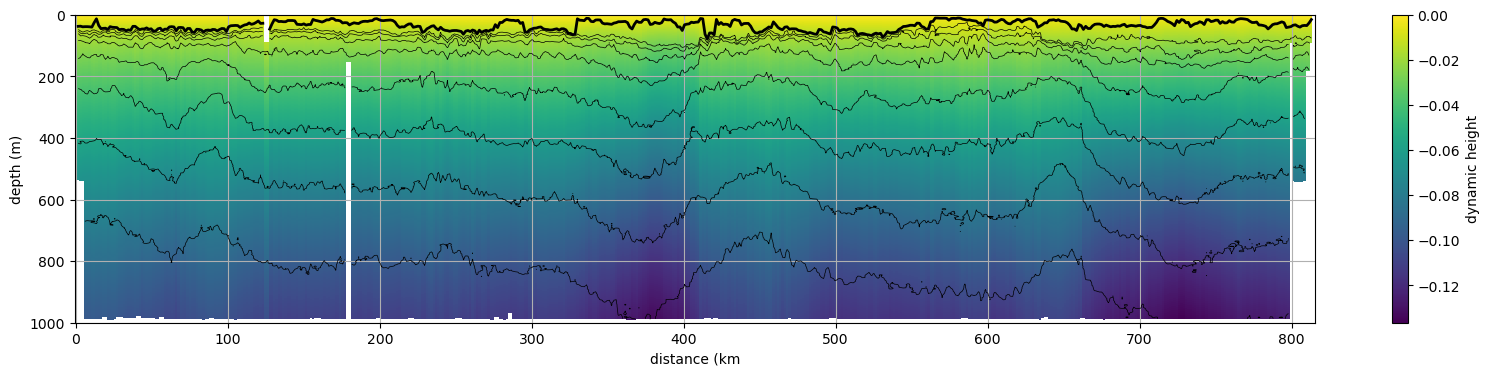

In [26]:


plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,dyn_height)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('dynamic height')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

In [27]:
import numpy as np

# Constants
Omega = 7.2921e-5  # angular velocity of the Earth in s^-1

latitudes = ds_glider.lat # Example latitudes

# Convert latitude from degrees to radians
latitudes_radians = np.radians(latitudes)

# Calculate the Coriolis parameter f for each latitude
f = 2 * Omega * np.sin(latitudes_radians)

# Print the calculated f values
print("Coriolis parameter (f):", f)


Coriolis parameter (f): <xarray.DataArray 'lat' (distance: 544)>
array([-8.88172465e-05, -8.88425586e-05, -8.88608042e-05, -8.88651462e-05,
       -8.88705770e-05, -8.88748379e-05, -8.88832339e-05, -8.88823122e-05,
       -8.88802502e-05, -8.88779078e-05, -8.88721743e-05, -8.88638644e-05,
       -8.88502090e-05, -8.88426065e-05, -8.88445577e-05, -8.88412816e-05,
       -8.88354382e-05, -8.88298249e-05, -8.88230466e-05, -8.88138199e-05,
       -8.88062506e-05, -8.87995030e-05, -8.87978189e-05, -8.87960860e-05,
       -8.87951875e-05, -8.87934068e-05, -8.87900686e-05, -8.87865779e-05,
       -8.87799307e-05, -8.87558522e-05, -8.87269844e-05, -8.87146806e-05,
       -8.87216541e-05, -8.87259787e-05, -8.87278829e-05, -8.87092983e-05,
       -8.86828654e-05, -8.86433684e-05, -8.86280893e-05, -8.85940767e-05,
       -8.85726187e-05, -8.85563004e-05, -8.85491661e-05, -8.85490295e-05,
       -8.85583428e-05, -8.85722657e-05, -8.85927188e-05, -8.86165598e-05,
       -8.86441205e-05, -8.86726308

In [28]:

# Extract dynamic height, Coriolis parameter, depth, and distance
dynamic_height = dyn_height # shape: (depth_points, distance_points)
depth = ds_glider['ctd_depth'].values  # shape: (depth_points,)
distance = ds_glider['distance'].values  # shape: (distance_points,)


# L is the distance resolution in meters
L = 1.5e3  # convert km to meters

# Reshape f to (1, 543) to align with the number of distances in dynamic_height
f_expanded = f.values[np.newaxis, :]  # shape: (1, 543)

# Now repeat the values along the depth dimension (2001 times)
f_repeated = np.repeat(f_expanded, dynamic_height.shape[0], axis=0)  # shape: (2001, 543)

# Now calculate geostrophic velocity using dynamic_height
geostrophic_velocity = dynamic_height / (f_repeated * L)  # shape: (2001, 544)



# Print the shape of geostrophic_velocity
print(f"Shape of geostrophic_velocity: {geostrophic_velocity.shape}")
# Inspect results
print(f"Geostrophic velocity values:\n {geostrophic_velocity}")
print(f"Min velocity: {np.min(geostrophic_velocity)}, Max velocity: {np.max(geostrophic_velocity)}")


Shape of geostrophic_velocity: (2001, 544)
Geostrophic velocity values:
 [[       nan        nan        nan ... 0.00028853        nan        nan]
 [       nan        nan 0.00131902 ... 0.00111079        nan        nan]
 [       nan 0.00219116 0.00215931 ... 0.00204435 0.00179501        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]
Min velocity: nan, Max velocity: nan


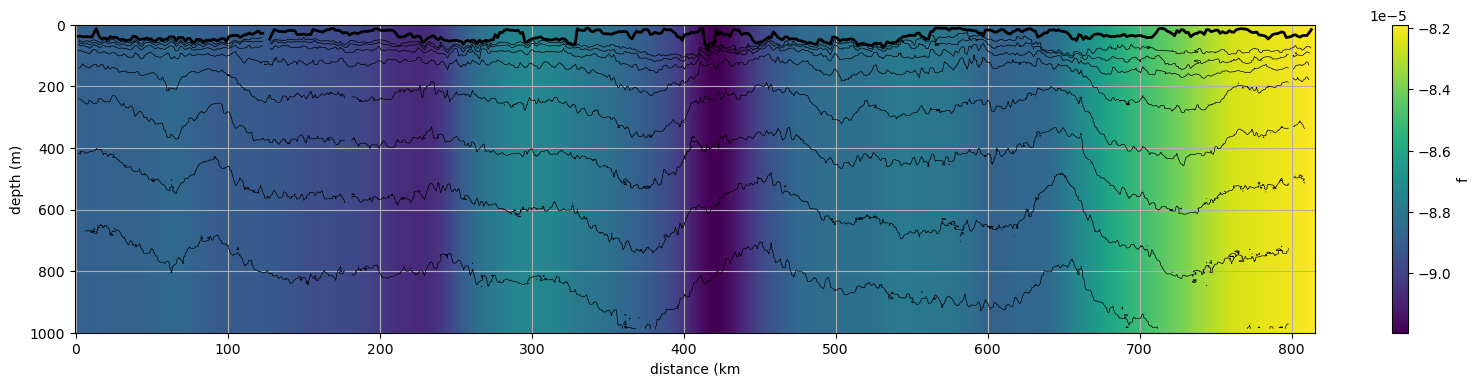

In [29]:
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,f_repeated)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('f')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

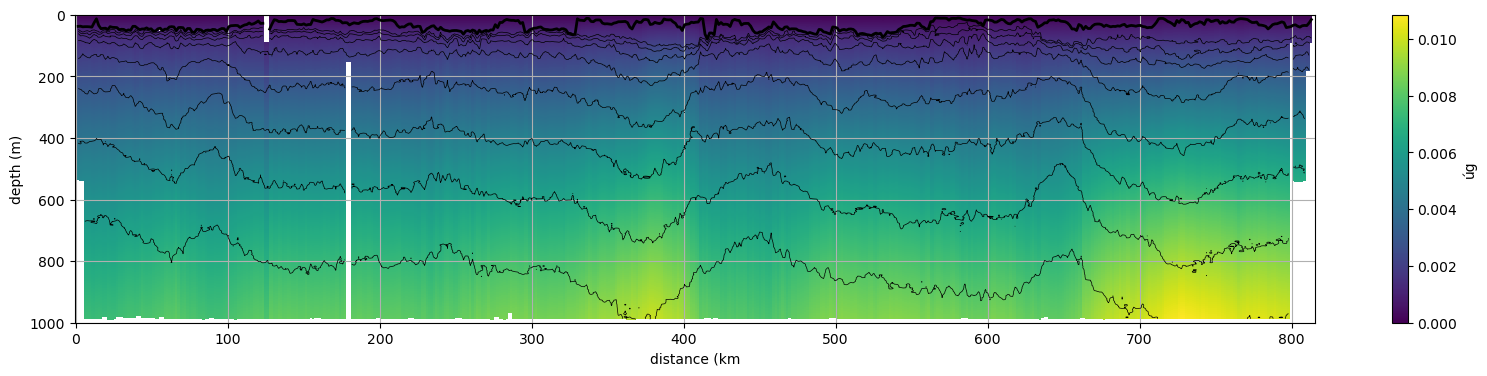

In [30]:
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,geostrophic_velocity/100)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('úg')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

In [31]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

# Function to linearly interpolate NaN values in each row (depth)
def nan_interpolation(data):
    for i in range(data.shape[0]):  # Loop over each depth level
        # Get valid indices (non-NaN)
        valid = ~np.isnan(data[i, :])
        if valid.any():
            # Interpolate over the non-NaN values
            interp_func = interp1d(np.flatnonzero(valid), data[i, valid], bounds_error=False, fill_value="extrapolate")
            data[i, :] = interp_func(np.arange(data.shape[1]))
    return data

# Assuming 'geostrophic_velocity' is your original 2D array (depth, distance)
geostrophic_velocity = nan_interpolation(geostrophic_velocity)

# Now apply Gaussian smoothing
grid_resolution = 1.5  # km
smoothing_length_km = 10.0
sigma_horizontal = smoothing_length_km / grid_resolution

# Smoothing only in the distance dimension (2D array: depth, distance)
sigma = [0, sigma_horizontal]

# Apply Gaussian filter
smoothed_velocity = gaussian_filter(geostrophic_velocity, sigma=sigma)

print(smoothed_velocity)



[[0.00019069 0.00019785 0.00021152 ... 0.00021537 0.00021735 0.00021851]
 [0.00133518 0.0013341  0.00133193 ... 0.00108231 0.00108569 0.0010874 ]
 [0.00213313 0.00213229 0.00213062 ... 0.00191514 0.00190826 0.00190472]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


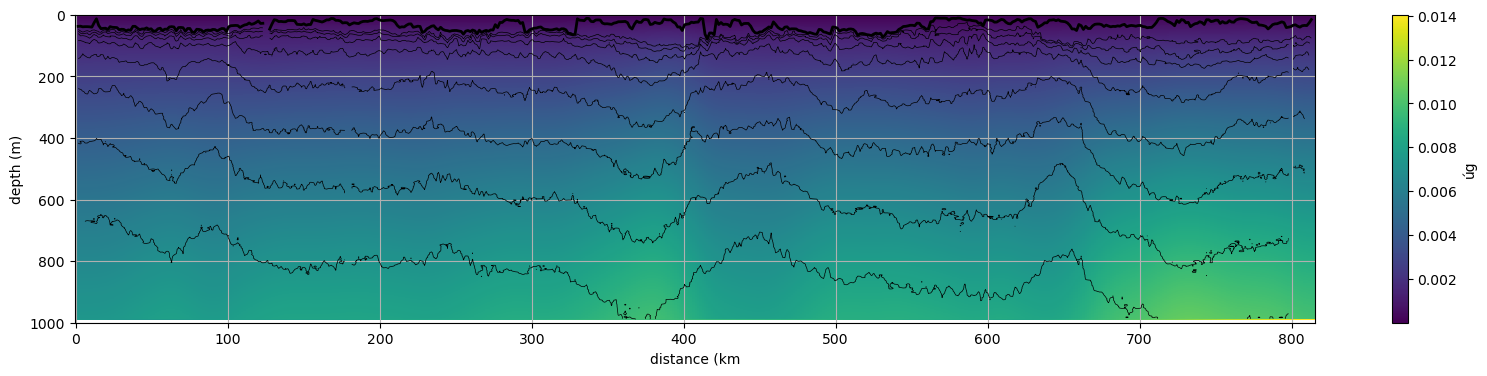

In [32]:
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,smoothed_velocity/100)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('úg')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

## geostrophic dynamic height 

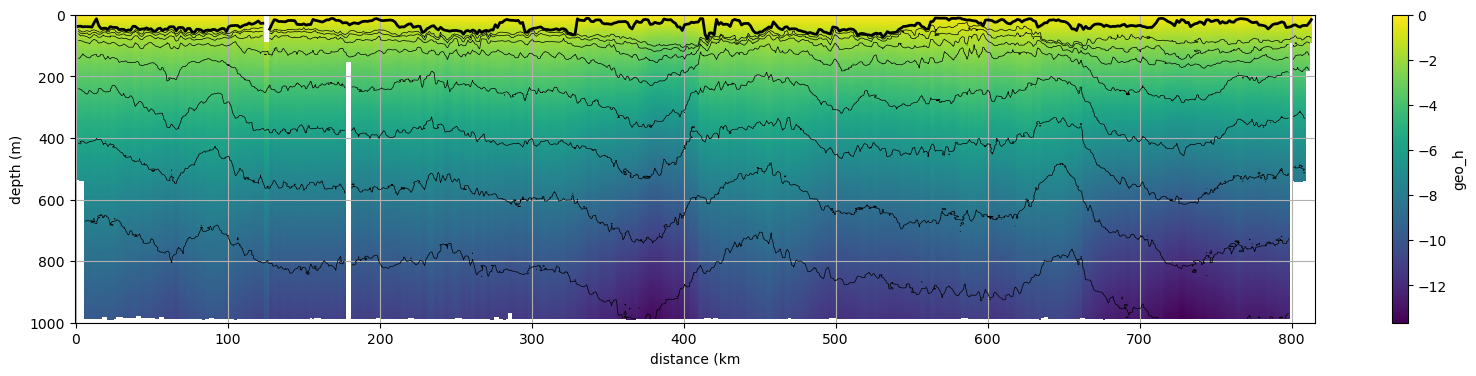

In [33]:
# Calculate geopotential anomaly and geostrophic velocities for all transects
geo_h = gsw.geo_strf_dyn_height(ds_glider.salinity, ds_glider.temp, ds_glider.p, p_ref=0)
plt.figure(figsize=(20,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,geo_h)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('geo_h')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

## Geostrophic velocity from dynamic height, not referenced with bottom yet!

In [34]:
# Assuming geo_h shape: (2001, 544)
# Assuming ds_glider.p shape: (2001, 544)

# Use the original 1D longitude and latitude arrays
lon_1d = ds_glider.long.values  # Original longitude array (shape: (544,))
lat_1d = ds_glider.lat.values    # Original latitude array (shape: (544,))
pressure_levels = ds_glider.p  # Assuming this is the pressure array with shape (2001, 544)

# Create a masked array for geo_h
geo_h_masked = np.ma.masked_invalid(geo_h)

# Calculate geostrophic velocity components
gv, m_lon, m_lat = gsw.geostrophy.geostrophic_velocity(geo_h_masked, lon_1d, lat_1d, pressure_levels)

# Output shapes of the results
print(f"Geostrophic velocity shape: {gv.shape}")
print(f"Longitude shape: {m_lon.shape}")
print(f"Latitude shape: {m_lat.shape}")


zeros_column = np.zeros((2001, 1))  # Create a column of zeros with shape (2001, 1)

# Concatenate the zeros column with gv along the second axis
gv = np.hstack((zeros_column, gv)) # Shape will now be (2001, 544)


Geostrophic velocity shape: (2001, 543)
Longitude shape: (543,)
Latitude shape: (543,)


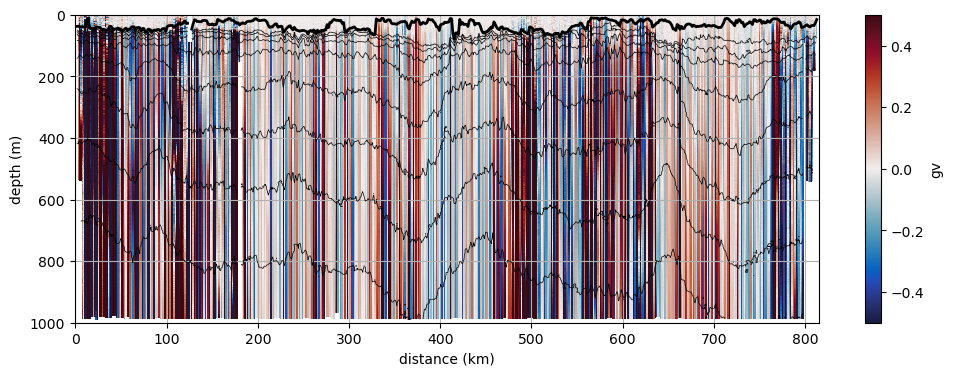

In [35]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,gv,cmap=cmo.balance,vmin=-0.5, vmax=0.5)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('gv')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

## geostrophic velocity referenced with bottom

In [36]:
# Reference geostrophic velocities to the bottom
def reference_to_bottom(gv_data):
    gv_bottom_ref = gv_data - gv_data[1950, :]
    gv_mean_bottom = np.nanmean(gv_bottom_ref,axis=0)
    return gv_bottom_ref, gv_mean_bottom

gv_ref_bottom, gv_mean_bottom = reference_to_bottom(gv)

Text(0.5, 1.0, 'referenced with bottom')

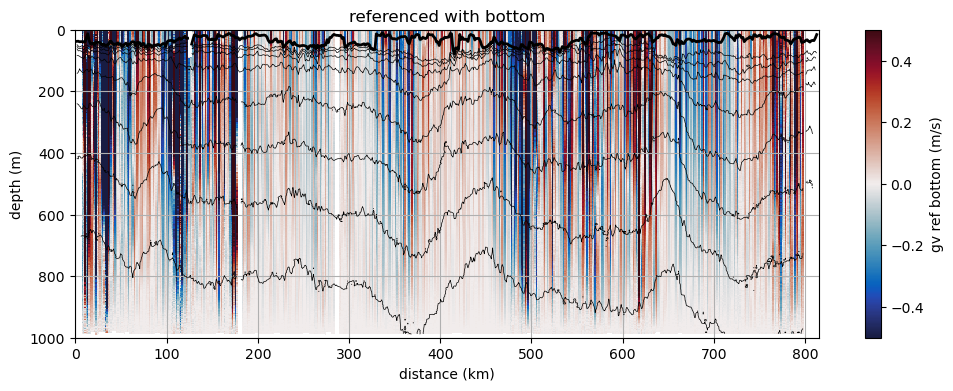

In [37]:
plt.figure(figsize=(12,4))
plt.pcolormesh(ds_glider.distance,ds_glider.ctd_depth,gv_ref_bottom,cmap=cmo.balance,vmin= -0.5,vmax=0.5)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth =2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
cbar = plt.colorbar()
cbar.set_label('gv ref bottom (m/s)')
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
plt.title('referenced with bottom')

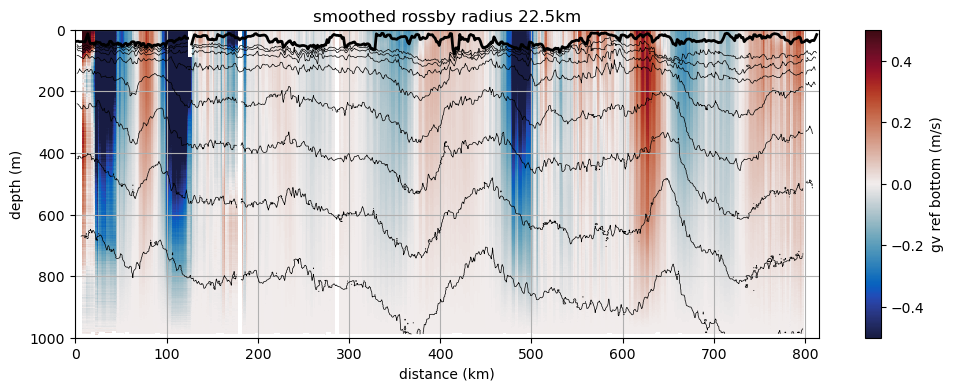

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo  # Assuming you're using cmocean for the colormap

# Convert the 2D array `gv_ref_bottom` to a DataFrame
df = pd.DataFrame(gv_ref_bottom)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply a rolling mean along each row (distance axis)
window_size = 15

# Calculate the rolling mean with center=True
smoothed_df = df.rolling(window=window_size, min_periods=1, axis=1, center=True).mean()

# Create a smoothed array while keeping original NaNs in place
gv_ref_bottom_smoothed = smoothed_df.where(~nan_mask, np.nan)

# Ensure the edges are handled correctly
for i in range(len(gv_ref_bottom_smoothed)):
    # For the first point, set to the mean of available points if it is not NaN in the original
    if pd.isna(gv_ref_bottom_smoothed.iloc[i, 0]) and not nan_mask.iloc[i, 0]:
        gv_ref_bottom_smoothed.iloc[i, 0] = df.iloc[i, :window_size].mean()

    # For the last point, set to the mean of available points if it is not NaN in the original
    if pd.isna(gv_ref_bottom_smoothed.iloc[i, -1]) and not nan_mask.iloc[i, -1]:
        gv_ref_bottom_smoothed.iloc[i, -1] = df.iloc[i, -window_size:].mean()

# Ensure original NaNs are retained
gv_ref_bottom_smoothed[nan_mask] = np.nan

# Plot the smoothed data
plt.figure(figsize=(12, 4))
plt.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, gv_ref_bottom_smoothed,
               cmap=cmo.balance, vmin=-0.5, vmax=0.5)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('gv ref bottom (m/s)')

# Add contours (optional)
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
plt.title('smoothed rossby radius 22.5km')

plt.show()


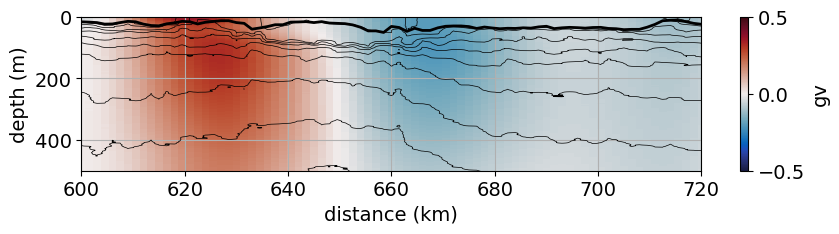

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter

# Convert the 2D array `gv_ref_bottom` to a DataFrame
df = pd.DataFrame(gv_ref_bottom_smoothed)

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply Gaussian filter
sigma = 3  # Adjust this parameter for more or less smoothing
gv_ref_bottom_smoothed_gaussian = gaussian_filter(df.fillna(0), sigma=sigma)

# Restore NaN values
gv_ref_bottom_smoothed_gaussian = np.where(nan_mask, np.nan, gv_ref_bottom_smoothed_gaussian)

# Plot the smoothed data
plt.figure(figsize=(10, 2))
plt.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, gv_ref_bottom_smoothed_gaussian,
               cmap=cmo.balance, vmin=-0.50, vmax=0.50)
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
plt.ylim(0,500)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('gv')

# Add contours (optional)
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
#plt.title('after gaussian filter')
plt.xlim(600,720)
plt.show()


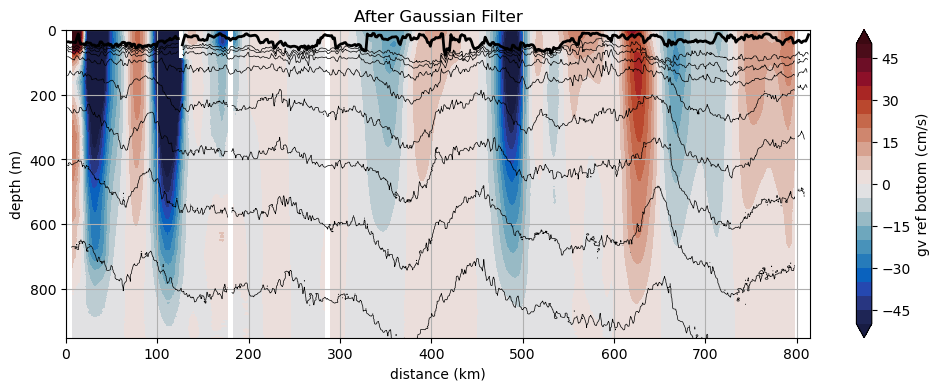

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from scipy.ndimage import gaussian_filter

# Convert the 2D array `gv_ref_bottom_smoothed` to a DataFrame
df = pd.DataFrame(gv_ref_bottom_smoothed) * 100  # Scale to cm/s if needed

# Create a mask for the original NaN values
nan_mask = df.isna()

# Apply Gaussian filter
sigma = 3  # Adjust this parameter for more or less smoothing
gv_ref_bottom_smoothed_gaussian = gaussian_filter(df.fillna(0), sigma=sigma)

# Restore NaN values
gv_ref_bottom_smoothed_gaussian = np.where(nan_mask, np.nan, gv_ref_bottom_smoothed_gaussian)

# Define the levels from -80 to 80 with steps of 5
contour_levels = np.arange(-50, 51, 5)  # Create an array from -80 to 80 with a step of 5

# Create the plot
plt.figure(figsize=(12, 4))

# Plot the smoothed data using contourf, limiting the depth to 950m
contour_plot = plt.contourf(ds_glider.distance, ds_glider.ctd_depth, gv_ref_bottom_smoothed_gaussian,
             levels=contour_levels, cmap=cmo.balance, extend='both')

# Add a black line for mixed layer densities
plt.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)

# Invert y-axis for depth
plt.gca().invert_yaxis()

# Set the y-axis limit to 950m
plt.ylim(0, 950)

# Add grid and labels
plt.grid()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')
plt.gca().invert_yaxis()
# Add colorbar
cbar = plt.colorbar(contour_plot)
cbar.set_label('gv ref bottom (cm/s)')

# Add contours (optional)
plt.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Add title
plt.title('After Gaussian Filter')

# Show the plot
plt.show()


# combined figure

C:\Users\rensk\AppData\Local\Temp\ipykernel_456\3694279208.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


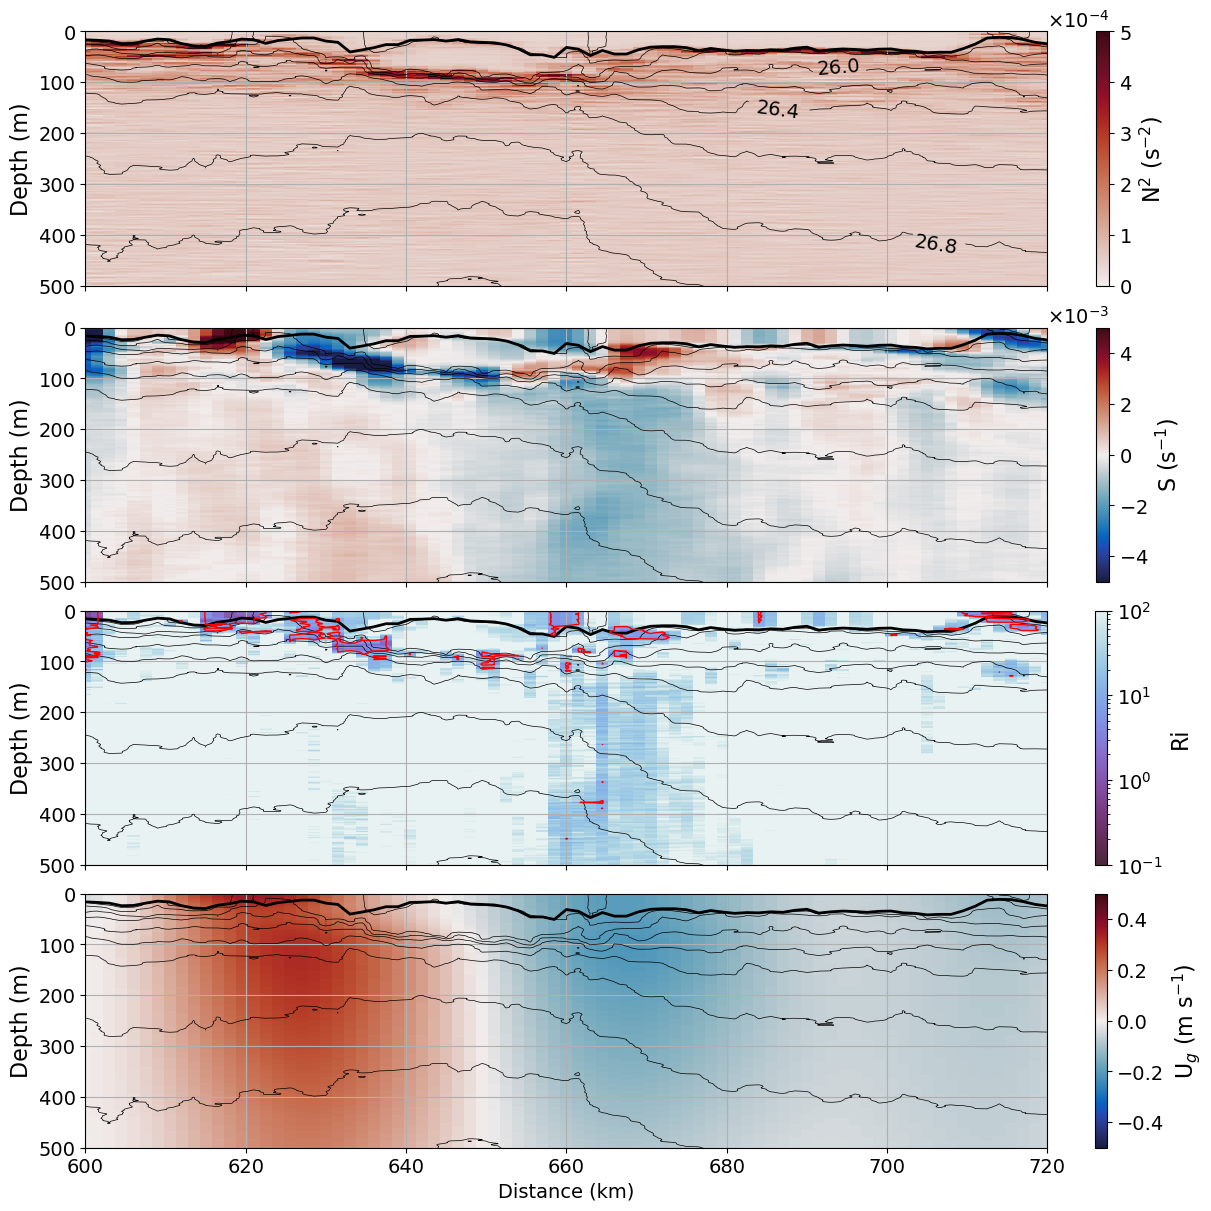

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, ScalarFormatter




# Replace zeros in Ri with a small positive value for logarithmic scaling
Ri_safe = np.where(Ri > 0, Ri, 1e-3)

# Adjust global font sizes for better readability
plt.rcParams.update({'font.size': 14})

# Create the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True, constrained_layout=True)

# Plot 1: N^2
ax = axes[0]
im1 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, N2, cmap=cmocean.cm.amp, vmin=0, vmax=0.0005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax, pad=-0.02)
cbar1.set_label('N$^2$ (s$^{-2}$)', fontsize=16)
cbar1.ax.tick_params(labelsize=14)
cbar1.formatter = ScalarFormatter(useMathText=True)
cbar1.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar1.update_ticks()
levels = np.arange(25, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(25.2, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax.clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

ax.contour(ds_glider.distance, ds_glider.ctd_depth, N2, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
beginning = 25  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)


# Plot 2: Shear
ax = axes[1]
im2 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, shear, cmap=cmocean.cm.balance, vmin=-0.005, vmax=0.005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax, pad=-0.02)
cbar2.set_label('S (s$^{-1}$)', fontsize=16)
cbar2.ax.tick_params(labelsize=14)
cbar2.formatter = ScalarFormatter(useMathText=True)
cbar2.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar2.update_ticks()
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)

# Plot 3: Ri
ax = axes[2]
im3 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, Ri_safe, cmap=cmocean.cm.dense_r, norm=LogNorm(vmin=1e-1, vmax=1e2), alpha=0.9)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar3 = fig.colorbar(im3, ax=ax, pad=0.03)
cbar3.set_label('Ri', fontsize=16)
cbar3.ax.tick_params(labelsize=14)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, Ri, levels=[10], colors='red', linewidths=1)

# Plot 4: gv_ref_bottom_smoothed_gaussian
ax = axes[3]
im4 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth,  gv_ref_bottom_smoothed_gaussian, cmap=cmocean.cm.balance, vmin=-0.50, vmax=0.50)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar4 = fig.colorbar(im4, ax=ax, pad=0.03)
cbar4.set_label('U$_g$ (m s$^{-1}$)', fontsize=16)
cbar4.ax.tick_params(labelsize=14)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax.set_xlabel('Distance (km)')


# Save and show the figure
plt.savefig('Combined_casestudy.png', bbox_inches='tight', dpi=100)
plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_456\322406758.py:37: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


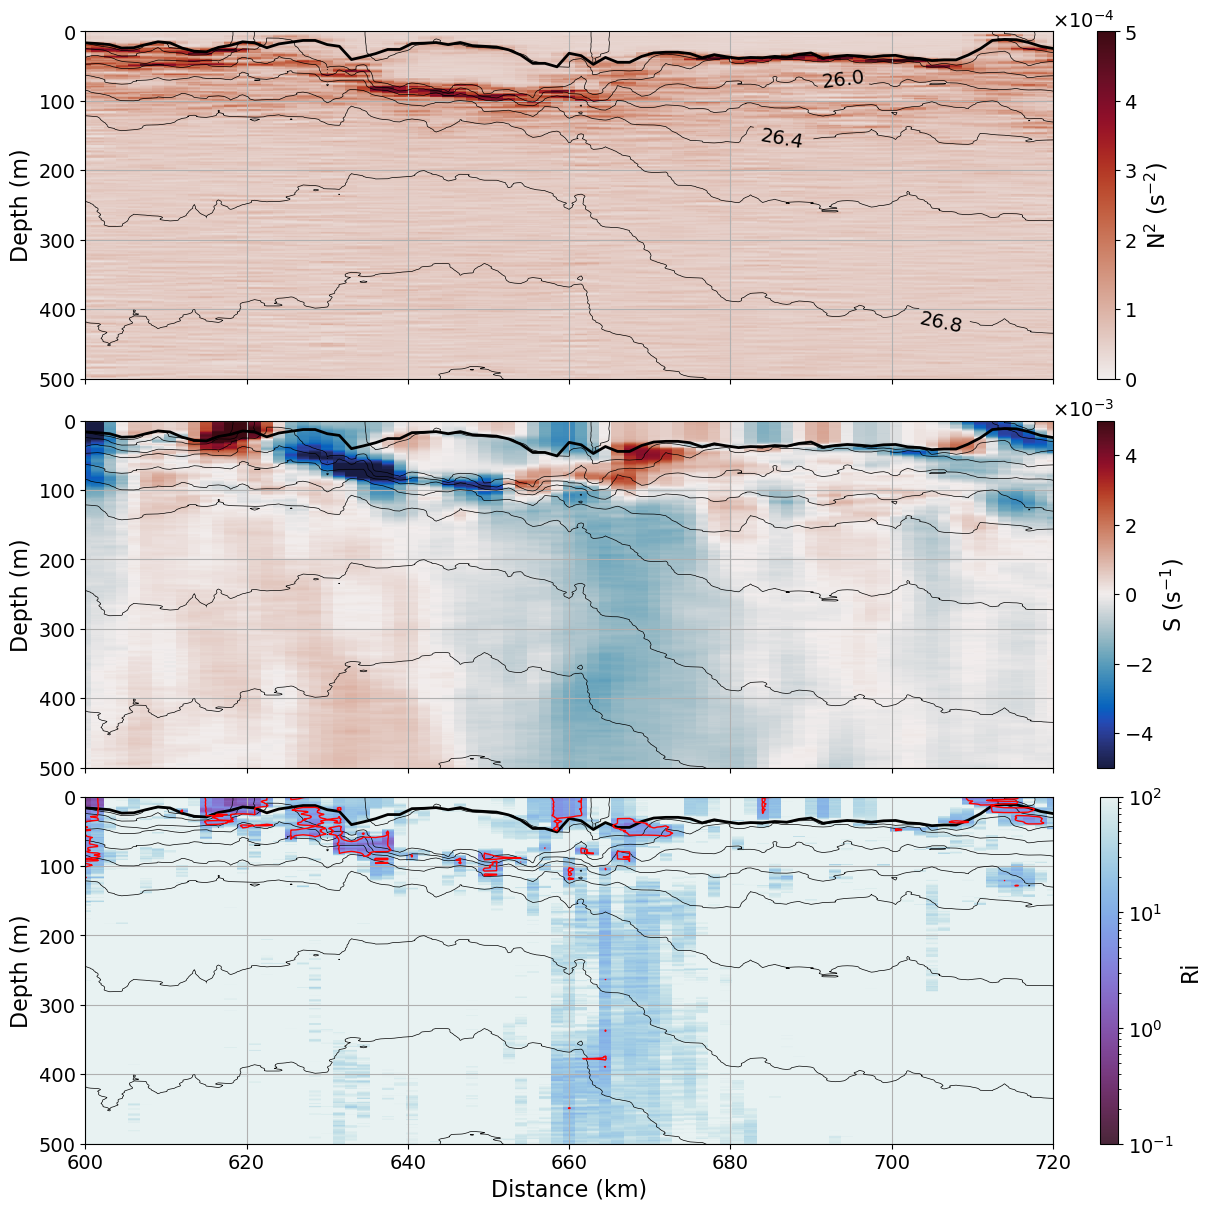

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

# Replace zeros in Ri with a small positive value for logarithmic scaling
Ri_safe = np.where(Ri > 0, Ri, 1e-3)

# Adjust global font sizes for better readability
plt.rcParams.update({'font.size': 14})

# Create the figure and subplots (3 panels instead of 4)
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, constrained_layout=True)

# Plot 1: N^2
ax = axes[0]
im1 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, N2, cmap=cmocean.cm.amp, vmin=0, vmax=0.0005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax, pad=-0.02)
cbar1.set_label('N$^2$ (s$^{-2}$)', fontsize=16)
cbar1.ax.tick_params(labelsize=14)
cbar1.formatter = ScalarFormatter(useMathText=True)
cbar1.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar1.update_ticks()
levels = np.arange(25, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(25.2, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax.clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

ax.contour(ds_glider.distance, ds_glider.ctd_depth, N2, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
beginning = 25  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)


# Plot 2: Shear
ax = axes[1]
im2 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, shear, cmap=cmocean.cm.balance, vmin=-0.005, vmax=0.005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax, pad=-0.02)
cbar2.set_label('S (s$^{-1}$)', fontsize=16)
cbar2.ax.tick_params(labelsize=14)
cbar2.formatter = ScalarFormatter(useMathText=True)
cbar2.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar2.update_ticks()
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)


# Plot 3: Ri
ax = axes[2]
im3 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, Ri_safe, cmap=cmocean.cm.dense_r, norm=LogNorm(vmin=1e-1, vmax=1e2), alpha=0.9)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar3 = fig.colorbar(im3, ax=ax, pad=0.03)
cbar3.set_label('Ri', fontsize=16)
cbar3.ax.tick_params(labelsize=14)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, Ri, levels=[10], colors='red', linewidths=1)
ax.set_xlabel('Distance (km)', fontsize=16)

# Save and show the figure
plt.savefig('Combined_casestudy_three_plots.png', bbox_inches='tight', dpi=100)
plt.show()


C:\Users\rensk\AppData\Local\Temp\ipykernel_456\2925476841.py:38: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs0.collections:


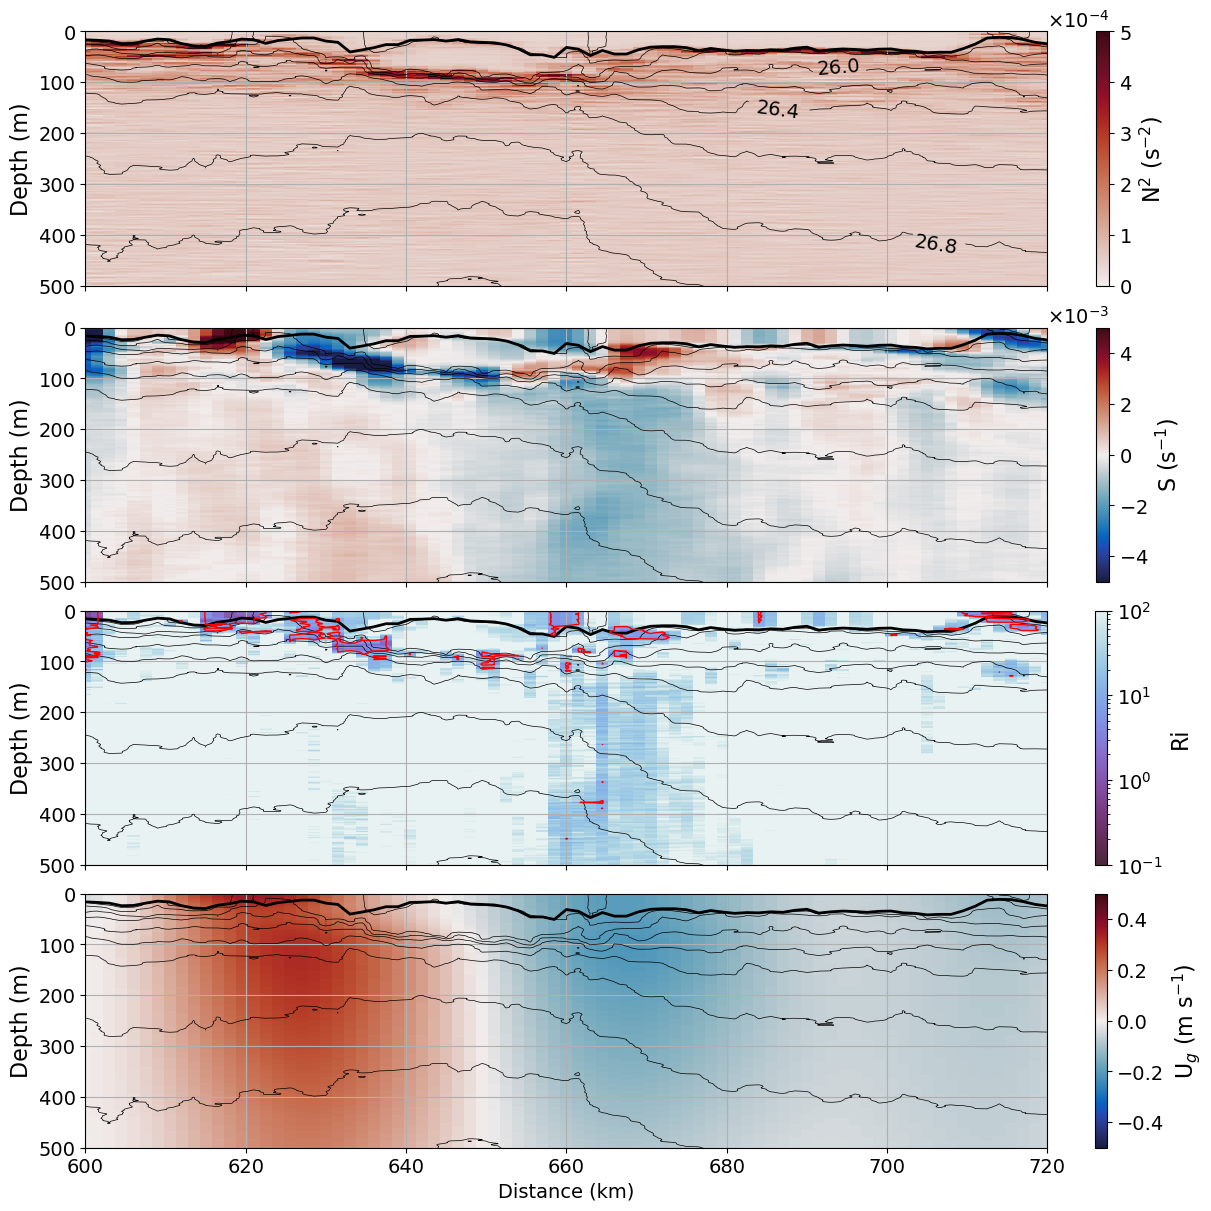

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

# Apply Gaussian filter for horizontal smoothing
def smooth_gaussian(arr, sigma=2):
    """Applies a Gaussian filter along the horizontal axis (axis=1)."""
    return gaussian_filter(arr, sigma=[0, sigma])  # No smoothing in depth (axis=0)

PV_smooth = smooth_gaussian(PV, sigma=1) 

# Create figure with 5 subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True, constrained_layout=True)

# Plot 1: N^2
ax = axes[0]
im1 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, N2, cmap=cmocean.cm.amp, vmin=0, vmax=0.0005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar1 = fig.colorbar(im1, ax=ax, pad=-0.02)
cbar1.set_label('N$^2$ (s$^{-2}$)', fontsize=16)
cbar1.ax.tick_params(labelsize=14)
cbar1.formatter = ScalarFormatter(useMathText=True)
cbar1.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar1.update_ticks()
levels = np.arange(25, 27.8 + 0.4, 0.4)  # Adjust these values as needed
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
levels2 = np.arange(25.2, 27.8 + 0.4, 0.4)  # Adjust these values as needed
cs0 = ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels2, colors='k', linewidths=0.5)

label_positions = []
for line in cs0.collections:
    for path in line.get_paths():
        vertices = path.vertices
        if len(vertices) > 0:
            mid_idx = 86*len(vertices) // 100  # Select the midpoint for a single label
            label_positions.append(vertices[mid_idx])

# Add labels only once per contour line
ax.clabel(cs0, inline=True, fontsize=14, fmt="%.1f", colors='black', manual=label_positions)

ax.contour(ds_glider.distance, ds_glider.ctd_depth, N2, levels=[0], colors='red', linewidths=0.5, alpha=0.5)

density = gsw.sigma0(ds_glider.salinity, ds_glider.temp)
beginning = 25  # Beginning value
ending = 27.8    # Ending value
spacing = 0.2    # Spacing between contour lines
levels = np.arange(beginning, ending + spacing, spacing)


# Plot 2: Shear
ax = axes[1]
im2 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, shear, cmap=cmocean.cm.balance, vmin=-0.005, vmax=0.005)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar2 = fig.colorbar(im2, ax=ax, pad=-0.02)
cbar2.set_label('S (s$^{-1}$)', fontsize=16)
cbar2.ax.tick_params(labelsize=14)
cbar2.formatter = ScalarFormatter(useMathText=True)
cbar2.formatter.set_powerlimits((-2, 2))  # Adjust the range for scientific notation
cbar2.update_ticks()
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)


# Plot 3: Ri
ax = axes[2]
im3 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth, Ri_safe, cmap=cmocean.cm.dense_r, norm=LogNorm(vmin=1e-1, vmax=1e2), alpha=0.9)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar3 = fig.colorbar(im3, ax=ax, pad=0.03)
cbar3.set_label('Ri', fontsize=16)
cbar3.ax.tick_params(labelsize=14)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, Ri, levels=[10], colors='red', linewidths=1)
#ax.set_xlabel('Distance (km)', fontsize=16)



# Plot 4: gv_ref_bottom_smoothed_gaussian
ax = axes[3]
im4 = ax.pcolormesh(ds_glider.distance, ds_glider.ctd_depth,  gv_ref_bottom_smoothed_gaussian, cmap=cmocean.cm.balance, vmin=-0.50, vmax=0.50)
ax.plot(mixed_layer_densities.distance, mixed_layer_densities.ctd_depth, color='k', linewidth=2)
ax.set_xlim(600, 720)
ax.set_ylim(500, 0)
ax.grid()
ax.set_ylabel('Depth (m)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
cbar4 = fig.colorbar(im5, ax=ax, pad=0.03)
cbar4.set_label('U$_g$ (m s$^{-1}$)', fontsize=16)
cbar4.ax.tick_params(labelsize=14)
ax.contour(ds_glider.distance, ds_glider.ctd_depth, density, levels=levels, colors='k', linewidths=0.5)
ax.set_xlabel('Distance (km)')

# (Your previous Plot 4 becomes Plot 5)

# Save and show the figure
plt.savefig('Combined_casestudy_with_EPV.png', bbox_inches='tight', dpi=100)
plt.show()
